**Mandatory Imports , Google Colab specific settings fo GPU and RAM and Google drive authentication**

In [1]:
# to be imported
import pandas as pd
import numpy as np
import sklearn
import re
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn import svm
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
#import xgboost as xgb
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.22.2.post1.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jul  3 09:32:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


**Loading consumer complain data and common classes for color**

In [5]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
print(color.GREEN + color.BOLD + color.UNDERLINE + "Bold Green string" + color.END)

Bold Green string


In [6]:
DataPath = "/content/drive/My Drive/data/consumer_complaints.csv"
df = pd.read_csv(DataPath)
print (df.shape)
print(df.dtypes)
df.head(5)



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(555956, 18)
date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09-03-2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09-03-2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


**Data Exploration: Missing value treatment, finding words correlation and labels frequency**

In [7]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.loc[missing_value_df['percent_missing'] > 0]

,column_name,percent_missing
zipcode,zipcode,0.810316
state,state,0.879026
sub_product,sub_product,28.477433
sub_issue,sub_issue,61.755786
consumer_consent_provided,consumer_consent_provided,77.793746
company_public_response,company_public_response,84.688896
tags,tags,85.977487
consumer_complaint_narrative,consumer_complaint_narrative,87.983581


In [8]:
# We are interested in categorizing consumer complains to appopriate categories of product and consumer_complaint_narrative and ;et us take only those complains that ar enot null
#dfData=df[("product","consumer_complaint_narrative")]
dfData=df[['product','consumer_complaint_narrative']].copy()
dfData.dropna(inplace=True)
print(dfData.shape)
dfData.head(10)

(66806, 2)


,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
190237,Mortgage,Experian is reporting my OPEN and CURRENT Mort...
190238,Mortgage,This complaint is against Wells Fargo Bank for...
190251,Mortgage,I spoke to XXXX of green tree representatives ...
190263,Credit card,i opened XXXX Bank of America credit cards 15-...
190264,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...


In [9]:
dfData.drop_duplicates()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
...,...,...
553083,Credit reporting,"XXXX XXXX is reporting incorrectly, payments h..."
553084,Credit reporting,Reflecting incorrect payment status. Have been...
553085,Payday loan,I have been paying {$180.00} a month through d...
553089,Mortgage,I recently became aware that Amerisave Mortgag...


In [10]:
dfData.groupby('product').consumer_complaint_narrative.nunique().sort_values(ascending=False).reset_index(name='count')

,product,count
0,Debt collection,17136
1,Mortgage,14910
2,Credit reporting,11873
3,Credit card,7909
4,Bank account or service,5688
5,Consumer Loan,3669
6,Student loan,2121
7,Prepaid card,859
8,Payday loan,726
9,Money transfers,665


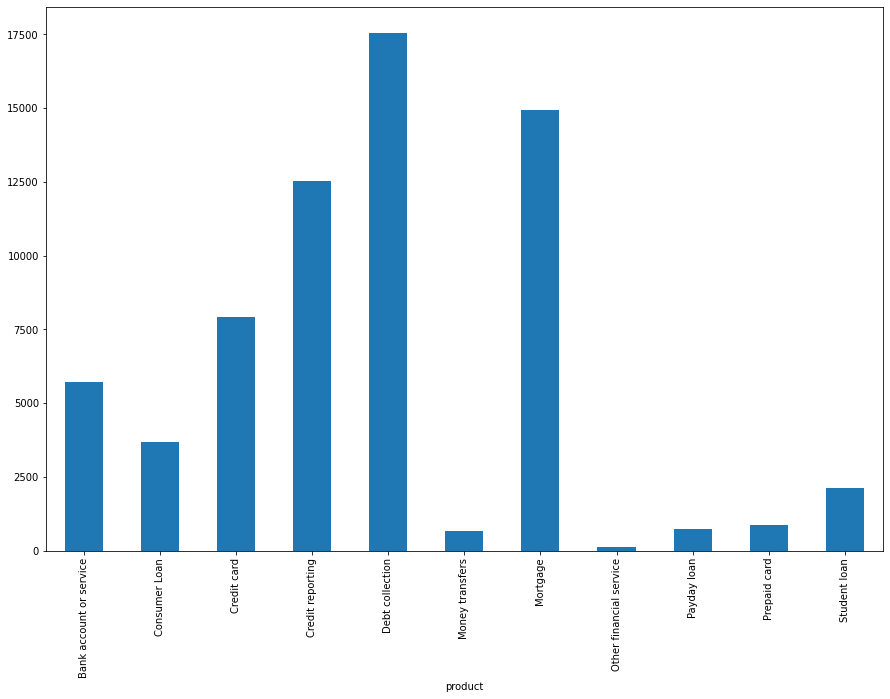

In [11]:
fig = plt.figure(figsize=(15,10))
dfData.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

**Performing vectorization to get correlation between words on 25% sample of data. Full data is crashing the notebook instance**

In [12]:
dfData2=dfData.sample(frac=0.25, replace=True, random_state=1).copy()

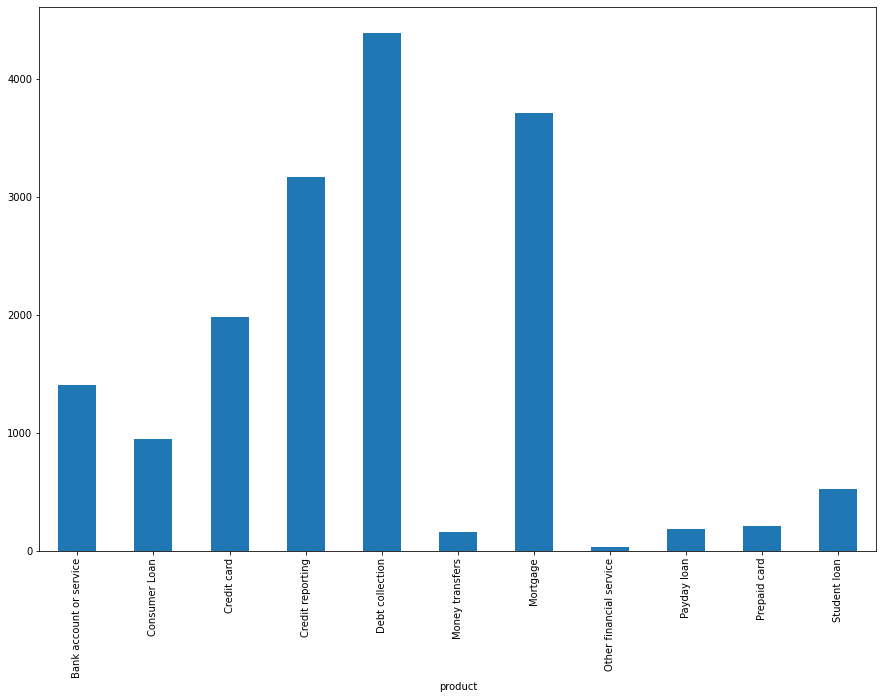

In [13]:

fig = plt.figure(figsize=(15,10))
dfData2.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [14]:
dfData2['Product_id'] = dfData2['product'].factorize()[0]
product_id_df = dfData2[['product', 'Product_id']].drop_duplicates().sort_values('Product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['Product_id', 'product']].values)
dfData2.head()

,product,consumer_complaint_narrative,Product_id
218690,Credit card,On XXXX/XXXX/2015 on my Amazon Store had promo...,0
491880,Credit reporting,I am requesting for the last time with this no...,1
260185,Prepaid card,"On XXXX XXXX, 2015, I received a prepaid XXXX ...",2
258032,Debt collection,A collection agency called Niagara XXXX XXXX p...,3
326773,Consumer Loan,I purchased a vehicle in XXXX XXXX with GM Fin...,4


In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(dfData2.consumer_complaint_narrative).toarray()
labels = dfData2.Product_id
print ('features shape:',features.shape)

features shape: (16702, 44790)


In [16]:
d = []
N = 2
for Product, Product_id in sorted(product_to_id.items()):
  features_chi2 = chi2(features, labels == Product_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  d.append(
        {
            'Product': Product,
            'MostCorrelatedUnigrams': unigrams[-N:],
            'MostCorrelatedBigrams':  bigrams[-N:]
        }
    )
dfCorr=pd.DataFrame(d)
pd.to_pickle(dfCorr, "dfCorr.pkl")

In [17]:
dfCorr = pd.read_pickle("dfCorr.pkl")
print ('dfCorr.shape',dfCorr.shape)
dfCorr.head(10)

dfCorr.shape (11, 3)


,Product,MostCorrelatedUnigrams,MostCorrelatedBigrams
0,Bank account or service,"[branch, overdraft]","[checking account, overdraft fees]"
1,Consumer Loan,"[vehicle, car]","[purchased vehicle, car loan]"
2,Credit card,"[capital, card]","[american express, credit card]"
3,Credit reporting,"[experian, equifax]","[trans union, credit report]"
4,Debt collection,"[collection, debt]","[debt collection, collection agency]"
5,Money transfers,"[wu, paypal]","[money transfer, western union]"
6,Mortgage,"[modification, mortgage]","[short sale, loan modification]"
7,Other financial service,"[cashing, understands]","[filled forms, 2015 cash]"
8,Payday loan,"[castle, payday]","[payday loans, payday loan]"
9,Prepaid card,"[rush, rushcard]","[money card, rush card]"


**Performing Data transformation to tokens and vectors using TF-IDF algorithm and then dividing the dataset into test and training and comparing multiple models for better accuracy**

In [18]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

In [19]:
X=dfData[['consumer_complaint_narrative']].copy()
y=dfData[['product']].copy()


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train.shape',X_train.shape)
print('X_test.shape',X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

X_train.shape (53444, 1)
X_test.shape (13362, 1)
y_train.shape (53444, 1)
y_test.shape (13362, 1)


In [21]:
vectorizer = TfidfVectorizer(stop_words="english",preprocessor=clean_text,ngram_range=(1, 2))
training_features = vectorizer.fit_transform(X_train["consumer_complaint_narrative"])    
test_features = vectorizer.transform(X_test["consumer_complaint_narrative"])
print('training_features',training_features.shape)
print('test_features',test_features.shape)

training_features (53444, 1325307)
test_features (13362, 1325307)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


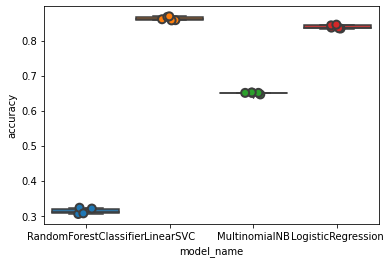

In [22]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, training_features,  y_train["product"], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [23]:
# Training on LinearSVC as that model has shown better accuracy
model = LinearSVC()
model.fit(training_features, y_train["product"])
y_pred = model.predict(test_features)

# Evaluation
acc = accuracy_score(y_test["product"], y_pred)



print("Accuracy of Model: {:.2f}".format(acc*100))
y_train["product"].head(10)
y_pred

Accuracy of Model: 87.08


array(['Debt collection', 'Mortgage', 'Credit card', ...,
       'Debt collection', 'Credit reporting', 'Credit reporting'],
      dtype=object)

In [24]:
VecorizerPath = "/content/drive/My Drive/MLModel/ConsumerComplainTfidfVectorizer.pkl"
joblib.dump(vectorizer, VecorizerPath,compress=3)

ModelPath = "/content/drive/My Drive/MLModel/ConsumerComplainModel.pkl"
joblib.dump(model, ModelPath,compress=3)

['/content/drive/My Drive/MLModel/ConsumerComplainModel.pkl']

In [25]:

data = {'consumer_complaint_narrative': ['My daughter has lost her money', 'Someone seems to stolen my identity','Unable to pay my mortgage']}
X=pd.DataFrame.from_dict(data)
vectorizer_load = joblib.load(VecorizerPath)
model_load = joblib.load(ModelPath)
predict_features = vectorizer_load.transform(X["consumer_complaint_narrative"])
y_pred = model_load.predict(predict_features)
y_pred

array(['Prepaid card', 'Credit reporting', 'Mortgage'], dtype=object)